In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.optim import SGD, Adam
import os
import warnings
from pathlib import Path

import quantnn as q

from convert_np import ConvertDatasetToNumpy, ComputeStatsFromNumpyFiles
from load_data import GOESRETRIEVALSDataset, Mask, Standardize, ToTensor
from models.FirstGenericNet import Net
from visualize.sample_plots import plotRandomSample


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class QuantileLoss:
    def __init__(self, quantiles):
        self.quantiles = quantiles
        
    def __call__(self, y_pred, y_true):
        return q.quantile_loss(y_pred, self.quantiles, y_true).mean()
            
def mask(output, y, fillval = -1):
    m = (y==-1)
    m_rep = m.unsqueeze(1).repeat(1,output.shape[1], 1, 1)
    output_masked = torch.clone(output)
    output_masked[torch.where(m_rep)] = fillval
    
    return(output_masked)

def train(model, X, y, optimizer, criterion):
    model.zero_grad()
    output = model(X)

    output_masked = mask(output, y)

    loss = criterion(output_masked, y)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
    loss.backward()
    optimizer.step()

    return loss


In [6]:

channels = [8,13]

EPOCHS = 2
BATCH_SIZE = 2

quantiles = [0.01, 0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95, 0.99]

path_to_load_train_data = 'data/first_net_dataset/train/'
path_to_save_train_data = 'data/first_net_dataset/train/npy_files'
path_to_stats = os.path.join(Path(path_to_save_train_data).parent, Path('stats.npy'))
path_to_state_dict = 'models/saved_models/FirstGenericNet_state_dict.pt'

ConvertDatasetToNumpy(path_to_load_data = path_to_load_train_data,
                      path_to_save_data = path_to_save_train_data)

train_dataset = GOESRETRIEVALSDataset(
    path_to_data = path_to_save_train_data,
    channels = channels, 
    transform = transforms.Compose([Mask(), 
                                    Standardize(path_to_save_train_data, path_to_stats, channels),
                                    ToTensor()])
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

[[233.22173112 269.27052031]
 [  7.07067325  20.06164785]]


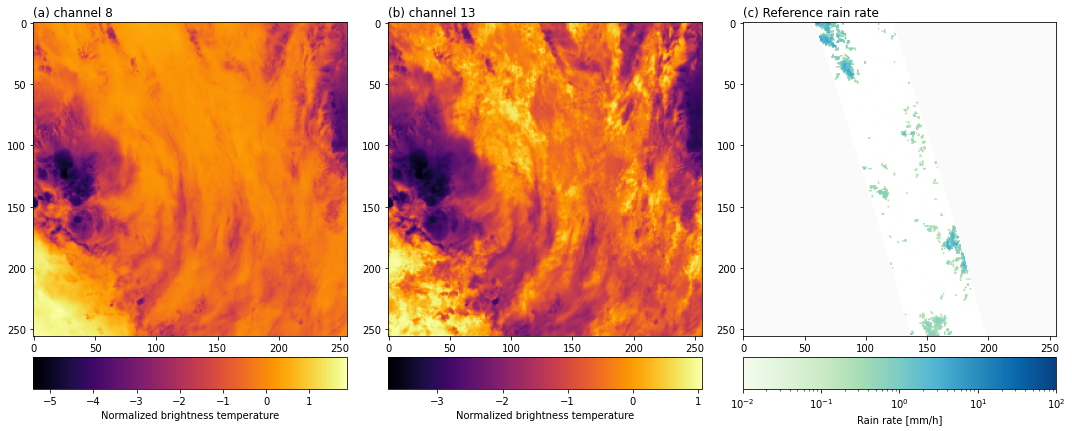

In [4]:
plotRandomSample(train_dataset)

In [ ]:
net = Net(len(quantiles), len(channels), 1)

criterion = QuantileLoss(quantiles)
optimizer = SGD(net.parameters(), lr = 0.1)


for epoch in range(EPOCHS):
    epoch_loss = 0
    for batch_index, batch in enumerate(train_dataloader):
        X = batch['box']
        y = batch['label']
        
        batch_loss = train(net, X, y, optimizer, criterion)
        print(batch_loss.item())
        epoch_loss += batch_loss.item()
        
    print(epoch, epoch_loss, 'average: ', epoch_loss/(batch_index+1))


In [ ]:
torch.save(net.state_dict(), path_to_state_dict)

In [8]:
#Test load data:
net = Net(len(quantiles), len(channels), 1)
net.load_state_dict(torch.load(path_to_state_dict))
net.eval()

Net(
  (c1): Conv2d(2, 128, kernel_size=(1, 1), stride=(1, 1))
  (c2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  (c3): Conv2d(128, 13, kernel_size=(1, 1), stride=(1, 1))
  (b): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [9]:
path_to_load_test_data = 'data/first_net_dataset/test/'
path_to_save_test_data = 'data/first_net_dataset/test/npy_files'

ConvertDatasetToNumpy(path_to_load_data = path_to_load_test_data,
                      path_to_save_data = path_to_save_test_data)

test_dataset = GOESRETRIEVALSDataset(
    path_to_data = path_to_save_test_data,
    channels = channels, 
    transform = transforms.Compose([Mask(),
                                    Standardize(path_to_save_test_data, path_to_stats, channels),
                                    ToTensor()])
)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

[[233.22173112 269.27052031]
 [  7.07067325  20.06164785]]


0.5


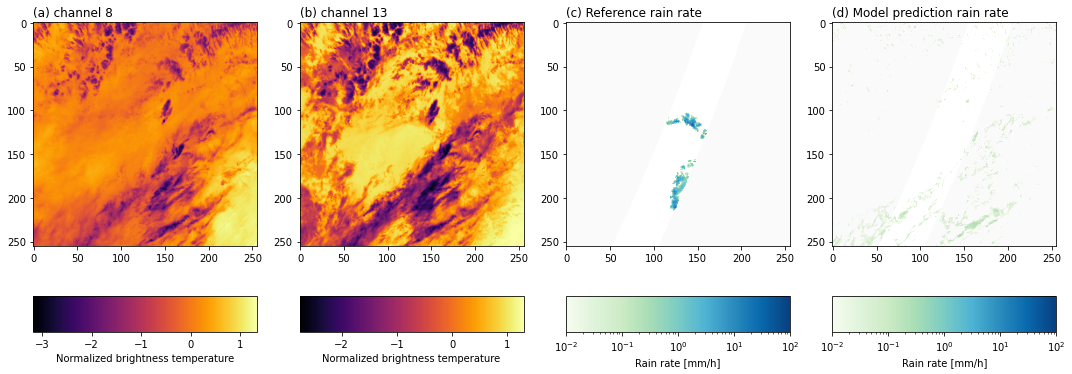

In [12]:
quantile_num=int(len(quantiles)/2)
print(quantiles[quantile_num])
plotRandomSample(test_dataset, net=net, quantile_num=quantile_num)

In [ ]:
tot_loss = 0
for batch_index, batch in enumerate(test_dataloader):

    X = batch['box']
    y = batch['label']

    output = net(X)
    
    output_masked = mask(output, y)
    
    batch_loss = criterion(output_masked, y)

    tot_loss += batch_loss.item()

print(tot_loss, tot_loss, 'average: ', tot_loss/batch_index)
